In [2]:
import tensorflow as tf

In [3]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [4]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

In [5]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved\assets


In [6]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

Now put this all together to build a basic model and train it from scratch.



First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [7]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

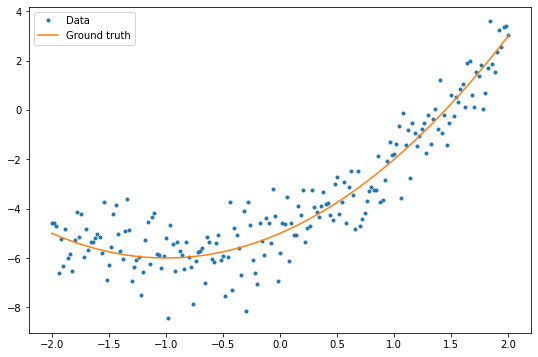

In [8]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

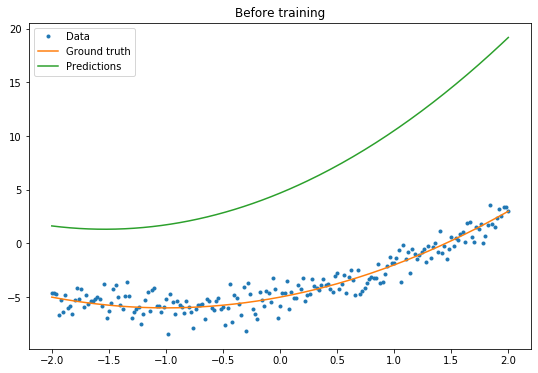

In [9]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b


quad_model = Model()

def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()
plot_preds(x, y, f, quad_model, 'Before training')

In [10]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

In [11]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 56.188
Mean squared error for step 10: 9.652
Mean squared error for step 20: 3.862
Mean squared error for step 30: 1.865
Mean squared error for step 40: 1.176
Mean squared error for step 50: 0.932
Mean squared error for step 60: 0.845
Mean squared error for step 70: 0.816
Mean squared error for step 80: 0.806
Mean squared error for step 90: 0.801




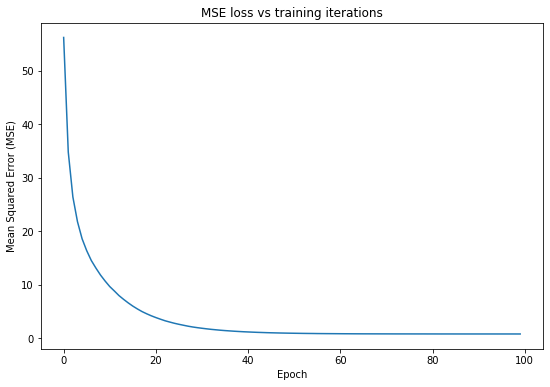

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

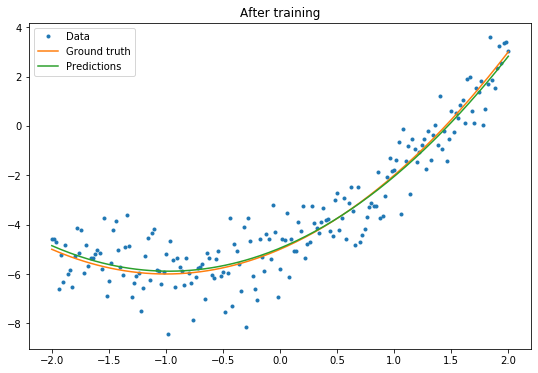

In [13]:
plot_preds(x, y, f, quad_model, 'After training')